# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = oversampling_SMOTE(join_c)
print (len(over[0]), len(over[1]), len(over[2])) 

7592 253
3796 1898 1898 126 63 64
7592 3796 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 3796, 1.0: 3796})
Counter({0.0: 1898, 1.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções e constantes auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [14]:
learnRate = 0.001
graficoName = "oversampling SMOTE, lr=0.001, rede="

## RNA 1 (10)

In [18]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.7005 - acc: 0.4506 - val_loss: 0.5639 - val_acc: 0.5037
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.4107 - acc: 0.5416 - val_loss: 0.3997 - val_acc: 0.5835
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.2624 - acc: 0.6621 - val_loss: 0.2885 - val_acc: 0.6301
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.1923 - acc: 0.7184 - val_loss: 0.2307 - val_acc: 0.6768
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.1603 - acc: 0.7550 - val_loss: 0.2007 - val_acc: 0.7060
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.1445 - acc: 0.7953 - val_loss: 0.1842 - val_acc: 0.7497
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.1357 - acc: 0.8248 - val_loss: 0.1740 - val_acc: 0.7874
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0894 - acc: 0.9115 - val_loss: 0.1080 - val_acc: 0.8957
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0892 - acc: 0.9117 - val_loss: 0.1077 - val_acc: 0.8957
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0890 - acc: 0.9117 - val_loss: 0.1074 - val_acc: 0.8962
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0888 - acc: 0.9120 - val_loss: 0.1073 - val_acc: 0.8965
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0887 - acc: 0.9121 - val_loss: 0.1071 - val_acc: 0.8965
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0885 - acc: 0.9120 - val_loss: 0.1068 - val_acc: 0.8967
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0884 - acc: 0.9123 - val_loss: 0.1065 - val_acc: 0.8973
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0882 - acc: 0.9124 - val_loss: 0.1063 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0820 - acc: 0.9156 - val_loss: 0.0978 - val_acc: 0.8996
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0819 - acc: 0.9154 - val_loss: 0.0977 - val_acc: 0.8996
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0818 - acc: 0.9153 - val_loss: 0.0975 - val_acc: 0.8999
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0817 - acc: 0.9157 - val_loss: 0.0976 - val_acc: 0.8996
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0816 - acc: 0.9153 - val_loss: 0.0975 - val_acc: 0.8999
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0815 - acc: 0.9154 - val_loss: 0.0975 - val_acc: 0.8996
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0814 - acc: 0.9150 - val_loss: 0.0972 - val_acc: 0.8999
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0813 - acc: 0.9154 - val_loss: 0.0971 -

7592/7592 [==============================] - 0s - loss: 0.0767 - acc: 0.9156 - val_loss: 0.0918 - val_acc: 0.9028
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0766 - acc: 0.9161 - val_loss: 0.0917 - val_acc: 0.9028
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0765 - acc: 0.9165 - val_loss: 0.0917 - val_acc: 0.9025
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0764 - acc: 0.9168 - val_loss: 0.0916 - val_acc: 0.9025
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0763 - acc: 0.9166 - val_loss: 0.0915 - val_acc: 0.9025
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0762 - acc: 0.9157 - val_loss: 0.0914 - val_acc: 0.9023
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0761 - acc: 0.9158 - val_loss: 0.0912 - val_acc: 0.9028
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0760 - acc: 0.9164 - val_loss: 0.0912 -

7592/7592 [==============================] - 0s - loss: 0.0711 - acc: 0.9222 - val_loss: 0.0839 - val_acc: 0.9060
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0711 - acc: 0.9220 - val_loss: 0.0838 - val_acc: 0.9062
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0710 - acc: 0.9222 - val_loss: 0.0836 - val_acc: 0.9062
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0709 - acc: 0.9220 - val_loss: 0.0836 - val_acc: 0.9065
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0709 - acc: 0.9219 - val_loss: 0.0835 - val_acc: 0.9067
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0708 - acc: 0.9220 - val_loss: 0.0835 - val_acc: 0.9067
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0707 - acc: 0.9223 - val_loss: 0.0833 - val_acc: 0.9065
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0707 - acc: 0.9224 - val_loss: 0.0833 -

7592/7592 [==============================] - 0s - loss: 0.0678 - acc: 0.9247 - val_loss: 0.0791 - val_acc: 0.9078
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0678 - acc: 0.9247 - val_loss: 0.0790 - val_acc: 0.9081
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0677 - acc: 0.9245 - val_loss: 0.0790 - val_acc: 0.9086
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0677 - acc: 0.9245 - val_loss: 0.0789 - val_acc: 0.9089
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0676 - acc: 0.9249 - val_loss: 0.0788 - val_acc: 0.9089
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0676 - acc: 0.9247 - val_loss: 0.0787 - val_acc: 0.9086
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0676 - acc: 0.9245 - val_loss: 0.0787 - val_acc: 0.9086
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0675 - acc: 0.9247 - val_loss: 0.0786 -

7592/7592 [==============================] - 0s - loss: 0.0652 - acc: 0.9273 - val_loss: 0.0746 - val_acc: 0.9091
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0652 - acc: 0.9280 - val_loss: 0.0745 - val_acc: 0.9091
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0652 - acc: 0.9277 - val_loss: 0.0745 - val_acc: 0.9091
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0651 - acc: 0.9274 - val_loss: 0.0746 - val_acc: 0.9094
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0651 - acc: 0.9277 - val_loss: 0.0743 - val_acc: 0.9091
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0651 - acc: 0.9280 - val_loss: 0.0743 - val_acc: 0.9091
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9281 - val_loss: 0.0743 - val_acc: 0.9086
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9280 - val_loss: 0.0741 -

7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9283 - val_loss: 0.0713 - val_acc: 0.9107
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9285 - val_loss: 0.0712 - val_acc: 0.9107
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9283 - val_loss: 0.0713 - val_acc: 0.9104
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9283 - val_loss: 0.0711 - val_acc: 0.9112
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9283 - val_loss: 0.0711 - val_acc: 0.9112
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9285 - val_loss: 0.0711 - val_acc: 0.9112
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9282 - val_loss: 0.0710 - val_acc: 0.9112
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9283 - val_loss: 0.0711 -

7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9291 - val_loss: 0.0689 - val_acc: 0.9125
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9293 - val_loss: 0.0689 - val_acc: 0.9125
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9294 - val_loss: 0.0689 - val_acc: 0.9125
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9294 - val_loss: 0.0688 - val_acc: 0.9125
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9291 - val_loss: 0.0688 - val_acc: 0.9128
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9294 - val_loss: 0.0688 - val_acc: 0.9128
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9297 - val_loss: 0.0688 - val_acc: 0.9131
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9293 - val_loss: 0.0688 -

7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9302 - val_loss: 0.0670 - val_acc: 0.9157
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9302 - val_loss: 0.0670 - val_acc: 0.9162
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9305 - val_loss: 0.0669 - val_acc: 0.9165
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9305 - val_loss: 0.0669 - val_acc: 0.9162
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9302 - val_loss: 0.0669 - val_acc: 0.9162
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0607 - acc: 0.9302 - val_loss: 0.0669 - val_acc: 0.9162
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9305 - val_loss: 0.0669 - val_acc: 0.9162
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9302 - val_loss: 0.0669 -

7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9314 - val_loss: 0.0654 - val_acc: 0.9173
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9315 - val_loss: 0.0654 - val_acc: 0.9175
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9314 - val_loss: 0.0654 - val_acc: 0.9173
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9312 - val_loss: 0.0654 - val_acc: 0.9175
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9314 - val_loss: 0.0653 - val_acc: 0.9175
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9316 - val_loss: 0.0652 - val_acc: 0.9183
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9312 - val_loss: 0.0653 - val_acc: 0.9173
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9312 - val_loss: 0.0653 -

7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9324 - val_loss: 0.0636 - val_acc: 0.9181
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9324 - val_loss: 0.0636 - val_acc: 0.9181
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9326 - val_loss: 0.0636 - val_acc: 0.9181
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9331 - val_loss: 0.0635 - val_acc: 0.9181
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9327 - val_loss: 0.0635 - val_acc: 0.9181
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9330 - val_loss: 0.0635 - val_acc: 0.9181
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9324 - val_loss: 0.0635 - val_acc: 0.9181
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9330 - val_loss: 0.0634 -

7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9337 - val_loss: 0.0621 - val_acc: 0.9191
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9340 - val_loss: 0.0621 - val_acc: 0.9197
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9340 - val_loss: 0.0620 - val_acc: 0.9197
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9337 - val_loss: 0.0620 - val_acc: 0.9197
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9340 - val_loss: 0.0620 - val_acc: 0.9197
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9340 - val_loss: 0.0620 - val_acc: 0.9197
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9340 - val_loss: 0.0620 - val_acc: 0.9197
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9339 - val_loss: 0.0620 -

7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9349 - val_loss: 0.0610 - val_acc: 0.9199
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9348 - val_loss: 0.0610 - val_acc: 0.9199
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9348 - val_loss: 0.0610 - val_acc: 0.9199
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9348 - val_loss: 0.0610 - val_acc: 0.9199
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0558 - acc: 0.9348 - val_loss: 0.0610 - val_acc: 0.9199
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0558 - acc: 0.9347 - val_loss: 0.0610 - val_acc: 0.9199
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0558 - acc: 0.9349 - val_loss: 0.0610 - val_acc: 0.9199
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0558 - acc: 0.9348 - val_loss: 0.0610 -

7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9360 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9361 - val_loss: 0.0605 - val_acc: 0.9210
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9359 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9360 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9359 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9359 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9361 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9357 - val_loss: 0.0604 -

7592/7592 [==============================] - 0s - loss: 0.0538 - acc: 0.9370 - val_loss: 0.0601 - val_acc: 0.9212
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0538 - acc: 0.9366 - val_loss: 0.0601 - val_acc: 0.9215
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0538 - acc: 0.9368 - val_loss: 0.0601 - val_acc: 0.9215
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0538 - acc: 0.9366 - val_loss: 0.0601 - val_acc: 0.9215
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0538 - acc: 0.9369 - val_loss: 0.0601 - val_acc: 0.9215
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0538 - acc: 0.9365 - val_loss: 0.0600 - val_acc: 0.9212
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0537 - acc: 0.9369 - val_loss: 0.0600 - val_acc: 0.9212
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0537 - acc: 0.9368 - val_loss: 0.0600 -

7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9373 - val_loss: 0.0598 - val_acc: 0.9215
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9373 - val_loss: 0.0598 - val_acc: 0.9223
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9374 - val_loss: 0.0598 - val_acc: 0.9220
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9370 - val_loss: 0.0597 - val_acc: 0.9223
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9374 - val_loss: 0.0597 - val_acc: 0.9226
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9370 - val_loss: 0.0597 - val_acc: 0.9226
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9374 - val_loss: 0.0597 - val_acc: 0.9226
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9376 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9386 - val_loss: 0.0594 - val_acc: 0.9241
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9381 - val_loss: 0.0594 - val_acc: 0.9241
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9382 - val_loss: 0.0594 - val_acc: 0.9241
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9388 - val_loss: 0.0594 - val_acc: 0.9241
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9386 - val_loss: 0.0594 - val_acc: 0.9241
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9388 - val_loss: 0.0595 - val_acc: 0.9236
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9382 - val_loss: 0.0594 - val_acc: 0.9241
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9385 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9391 - val_loss: 0.0591 - val_acc: 0.9236
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9393 - val_loss: 0.0591 - val_acc: 0.9236
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9394 - val_loss: 0.0591 - val_acc: 0.9236
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9394 - val_loss: 0.0591 - val_acc: 0.9239
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9393 - val_loss: 0.0591 - val_acc: 0.9236
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9394 - val_loss: 0.0590 - val_acc: 0.9236
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9393 - val_loss: 0.0591 - val_acc: 0.9233
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9394 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9403 - val_loss: 0.0588 - val_acc: 0.9239
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9406 - val_loss: 0.0588 - val_acc: 0.9239
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9403 - val_loss: 0.0589 - val_acc: 0.9236
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9405 - val_loss: 0.0588 - val_acc: 0.9239
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9403 - val_loss: 0.0588 - val_acc: 0.9239
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9406 - val_loss: 0.0588 - val_acc: 0.9239
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9406 - val_loss: 0.0588 - val_acc: 0.9239
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9401 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9407 - val_loss: 0.0587 - val_acc: 0.9236
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9409 - val_loss: 0.0586 - val_acc: 0.9236
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9409 - val_loss: 0.0586 - val_acc: 0.9236
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9410 - val_loss: 0.0587 - val_acc: 0.9236
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9407 - val_loss: 0.0587 - val_acc: 0.9236
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9409 - val_loss: 0.0587 - val_acc: 0.9239
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9407 - val_loss: 0.0587 - val_acc: 0.9239
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9407 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9413 - val_loss: 0.0587 - val_acc: 0.9239
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9415 - val_loss: 0.0585 - val_acc: 0.9236
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9413 - val_loss: 0.0586 - val_acc: 0.9236
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9413 - val_loss: 0.0586 - val_acc: 0.9239
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9413 - val_loss: 0.0585 - val_acc: 0.9239
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9414 - val_loss: 0.0585 - val_acc: 0.9239
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9413 - val_loss: 0.0586 - val_acc: 0.9239
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9414 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9416 - val_loss: 0.0583 - val_acc: 0.9231
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9420 - val_loss: 0.0583 - val_acc: 0.9228
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9422 - val_loss: 0.0583 - val_acc: 0.9228
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9420 - val_loss: 0.0583 - val_acc: 0.9228
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9422 - val_loss: 0.0584 - val_acc: 0.9228
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9418 - val_loss: 0.0583 - val_acc: 0.9228
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9419 - val_loss: 0.0583 - val_acc: 0.9228
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9420 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0493 - acc: 0.9423 - val_loss: 0.0582 - val_acc: 0.9220
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0493 - acc: 0.9424 - val_loss: 0.0582 - val_acc: 0.9218
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0493 - acc: 0.9426 - val_loss: 0.0583 - val_acc: 0.9218
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0493 - acc: 0.9426 - val_loss: 0.0583 - val_acc: 0.9218
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0493 - acc: 0.9424 - val_loss: 0.0583 - val_acc: 0.9218
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0493 - acc: 0.9424 - val_loss: 0.0582 - val_acc: 0.9220
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0493 - acc: 0.9424 - val_loss: 0.0583 - val_acc: 0.9218
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0493 - acc: 0.9426 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9426 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9423 - val_loss: 0.0583 - val_acc: 0.9231
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9424 - val_loss: 0.0582 - val_acc: 0.9231
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9424 - val_loss: 0.0581 - val_acc: 0.9233
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9424 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9427 - val_loss: 0.0583 - val_acc: 0.9231
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9423 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9424 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0487 - acc: 0.9427 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0487 - acc: 0.9430 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0487 - acc: 0.9430 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0487 - acc: 0.9427 - val_loss: 0.0581 - val_acc: 0.9236
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0487 - acc: 0.9427 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0487 - acc: 0.9426 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0487 - acc: 0.9424 - val_loss: 0.0581 - val_acc: 0.9236
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0487 - acc: 0.9427 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9426 - val_loss: 0.0581 - val_acc: 0.9249
Epoch 1639/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9423 - val_loss: 0.0582 - val_acc: 0.9249
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9424 - val_loss: 0.0582 - val_acc: 0.9247
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9424 - val_loss: 0.0582 - val_acc: 0.9249
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9427 - val_loss: 0.0581 - val_acc: 0.9249
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0484 - acc: 0.9423 - val_loss: 0.0582 - val_acc: 0.9249
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0484 - acc: 0.9427 - val_loss: 0.0581 - val_acc: 0.9249
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0484 - acc: 0.9427 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0482 - acc: 0.9428 - val_loss: 0.0582 - val_acc: 0.9254
Epoch 1702/2000
7592/7592 [==============================] - 0s - loss: 0.0482 - acc: 0.9432 - val_loss: 0.0581 - val_acc: 0.9257
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0482 - acc: 0.9431 - val_loss: 0.0582 - val_acc: 0.9257
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0482 - acc: 0.9427 - val_loss: 0.0583 - val_acc: 0.9252
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0482 - acc: 0.9428 - val_loss: 0.0583 - val_acc: 0.9252
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0482 - acc: 0.9430 - val_loss: 0.0583 - val_acc: 0.9252
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0482 - acc: 0.9431 - val_loss: 0.0584 - val_acc: 0.9252
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0482 - acc: 0.9424 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9432 - val_loss: 0.0584 - val_acc: 0.9254
Epoch 1765/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9431 - val_loss: 0.0585 - val_acc: 0.9257
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9430 - val_loss: 0.0584 - val_acc: 0.9257
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9430 - val_loss: 0.0583 - val_acc: 0.9257
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9432 - val_loss: 0.0584 - val_acc: 0.9257
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9432 - val_loss: 0.0584 - val_acc: 0.9257
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9431 - val_loss: 0.0585 - val_acc: 0.9252
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9431 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0478 - acc: 0.9428 - val_loss: 0.0584 - val_acc: 0.9254
Epoch 1828/2000
7592/7592 [==============================] - 0s - loss: 0.0478 - acc: 0.9431 - val_loss: 0.0584 - val_acc: 0.9254
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0478 - acc: 0.9431 - val_loss: 0.0585 - val_acc: 0.9254
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0478 - acc: 0.9428 - val_loss: 0.0584 - val_acc: 0.9254
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0478 - acc: 0.9430 - val_loss: 0.0584 - val_acc: 0.9254
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0478 - acc: 0.9428 - val_loss: 0.0585 - val_acc: 0.9252
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0478 - acc: 0.9430 - val_loss: 0.0586 - val_acc: 0.9254
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0478 - acc: 0.9434 - val_loss: 0

In [22]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1952/1962 [============================>.] - ETA: 0s[0.046523179560823788, 0.93628950038816583]


<IPython.core.display.Javascript object>


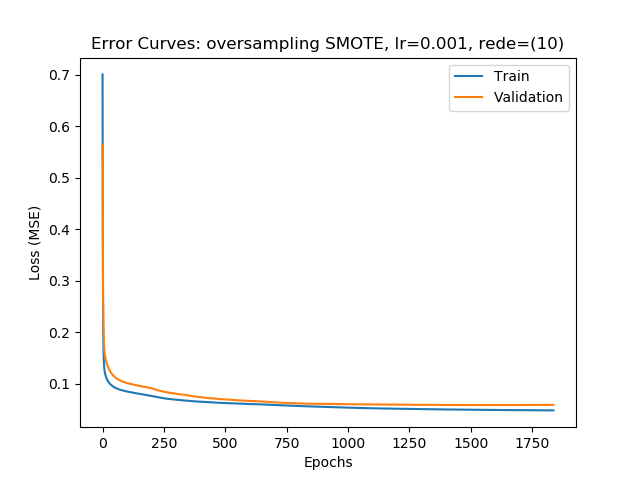

<IPython.core.display.Javascript object>


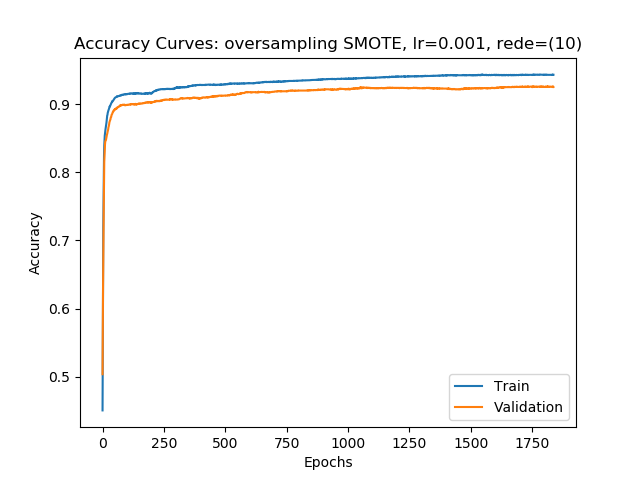

Matriz de confusão
[[1781  117]
 [   7   57]]

Train Loss:       0.0489
Validation Loss:  0.0580
Accuracy:         0.9368
MSE:              0.0632
AUROC:            0.9399


In [23]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [24]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.2796 - acc: 0.6048 - val_loss: 0.2740 - val_acc: 0.6246
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.1893 - acc: 0.7206 - val_loss: 0.2175 - val_acc: 0.7092
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.1550 - acc: 0.7578 - val_loss: 0.1913 - val_acc: 0.7289
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.1395 - acc: 0.8006 - val_loss: 0.1753 - val_acc: 0.7532
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.1302 - acc: 0.8193 - val_loss: 0.1642 - val_acc: 0.7835
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.1235 - acc: 0.8338 - val_loss: 0.1554 - val_acc: 0.8087
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.1182 - acc: 0.8473 - val_loss: 0.1485 - val_acc: 0.8214
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9301 - val_loss: 0.0848 - val_acc: 0.9073
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9301 - val_loss: 0.0845 - val_acc: 0.9075
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9303 - val_loss: 0.0845 - val_acc: 0.9078
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9310 - val_loss: 0.0844 - val_acc: 0.9078
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9306 - val_loss: 0.0843 - val_acc: 0.9078
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0684 - acc: 0.9316 - val_loss: 0.0842 - val_acc: 0.9078
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0683 - acc: 0.9326 - val_loss: 0.0841 - val_acc: 0.9081
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0681 - acc: 0.9319 - val_loss: 0.0839 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9369 - val_loss: 0.0782 - val_acc: 0.9139
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9369 - val_loss: 0.0782 - val_acc: 0.9139
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9366 - val_loss: 0.0781 - val_acc: 0.9139
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9370 - val_loss: 0.0781 - val_acc: 0.9139
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9370 - val_loss: 0.0780 - val_acc: 0.9139
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9369 - val_loss: 0.0778 - val_acc: 0.9136
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9369 - val_loss: 0.0778 - val_acc: 0.9139
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9370 - val_loss: 0.0780 -

7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9391 - val_loss: 0.0744 - val_acc: 0.9152
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0595 - acc: 0.9395 - val_loss: 0.0742 - val_acc: 0.9154
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9395 - val_loss: 0.0742 - val_acc: 0.9152
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0594 - acc: 0.9395 - val_loss: 0.0741 - val_acc: 0.9154
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9397 - val_loss: 0.0740 - val_acc: 0.9157
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9397 - val_loss: 0.0742 - val_acc: 0.9144
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0593 - acc: 0.9394 - val_loss: 0.0741 - val_acc: 0.9149
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0592 - acc: 0.9397 - val_loss: 0.0740 -

7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9407 - val_loss: 0.0714 - val_acc: 0.9170
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9416 - val_loss: 0.0713 - val_acc: 0.9170
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9413 - val_loss: 0.0712 - val_acc: 0.9170
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9414 - val_loss: 0.0713 - val_acc: 0.9170
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9415 - val_loss: 0.0712 - val_acc: 0.9170
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9414 - val_loss: 0.0711 - val_acc: 0.9175
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9414 - val_loss: 0.0711 - val_acc: 0.9170
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9413 - val_loss: 0.0710 -

7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9435 - val_loss: 0.0693 - val_acc: 0.9186
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9435 - val_loss: 0.0693 - val_acc: 0.9186
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9435 - val_loss: 0.0693 - val_acc: 0.9186
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9438 - val_loss: 0.0691 - val_acc: 0.9186
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9438 - val_loss: 0.0692 - val_acc: 0.9186
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0546 - acc: 0.9438 - val_loss: 0.0691 - val_acc: 0.9178
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0546 - acc: 0.9438 - val_loss: 0.0692 - val_acc: 0.9178
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0546 - acc: 0.9436 - val_loss: 0.0692 -

7592/7592 [==============================] - 0s - loss: 0.0530 - acc: 0.9456 - val_loss: 0.0673 - val_acc: 0.9197
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0530 - acc: 0.9452 - val_loss: 0.0673 - val_acc: 0.9197
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9455 - val_loss: 0.0673 - val_acc: 0.9197
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9457 - val_loss: 0.0671 - val_acc: 0.9197
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9455 - val_loss: 0.0671 - val_acc: 0.9194
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9457 - val_loss: 0.0671 - val_acc: 0.9197
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9455 - val_loss: 0.0671 - val_acc: 0.9197
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9456 - val_loss: 0.0671 -

7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9473 - val_loss: 0.0656 - val_acc: 0.9191
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9470 - val_loss: 0.0656 - val_acc: 0.9194
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9469 - val_loss: 0.0655 - val_acc: 0.9194
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9470 - val_loss: 0.0655 - val_acc: 0.9194
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9474 - val_loss: 0.0654 - val_acc: 0.9191
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9473 - val_loss: 0.0654 - val_acc: 0.9194
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9476 - val_loss: 0.0654 - val_acc: 0.9202
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9476 - val_loss: 0.0654 -

7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9482 - val_loss: 0.0641 - val_acc: 0.9218
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9485 - val_loss: 0.0640 - val_acc: 0.9218
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9482 - val_loss: 0.0641 - val_acc: 0.9212
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9484 - val_loss: 0.0640 - val_acc: 0.9210
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9486 - val_loss: 0.0640 - val_acc: 0.9218
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9484 - val_loss: 0.0640 - val_acc: 0.9215
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9484 - val_loss: 0.0640 - val_acc: 0.9218
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9482 - val_loss: 0.0642 -

7592/7592 [==============================] - 0s - loss: 0.0491 - acc: 0.9481 - val_loss: 0.0632 - val_acc: 0.9215
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0491 - acc: 0.9481 - val_loss: 0.0633 - val_acc: 0.9212
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0491 - acc: 0.9478 - val_loss: 0.0632 - val_acc: 0.9218
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0491 - acc: 0.9482 - val_loss: 0.0631 - val_acc: 0.9212
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9485 - val_loss: 0.0632 - val_acc: 0.9212
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9485 - val_loss: 0.0632 - val_acc: 0.9218
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9482 - val_loss: 0.0632 - val_acc: 0.9210
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9482 - val_loss: 0.0632 -

7592/7592 [==============================] - 0s - loss: 0.0481 - acc: 0.9488 - val_loss: 0.0627 - val_acc: 0.9220
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9489 - val_loss: 0.0628 - val_acc: 0.9220
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9490 - val_loss: 0.0628 - val_acc: 0.9223
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9494 - val_loss: 0.0628 - val_acc: 0.9223
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9492 - val_loss: 0.0626 - val_acc: 0.9226
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9493 - val_loss: 0.0627 - val_acc: 0.9220
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9493 - val_loss: 0.0627 - val_acc: 0.9220
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0479 - acc: 0.9494 - val_loss: 0.0628 -

7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9501 - val_loss: 0.0622 - val_acc: 0.9220
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9503 - val_loss: 0.0621 - val_acc: 0.9218
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9506 - val_loss: 0.0622 - val_acc: 0.9220
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9503 - val_loss: 0.0622 - val_acc: 0.9220
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9509 - val_loss: 0.0622 - val_acc: 0.9220
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9505 - val_loss: 0.0622 - val_acc: 0.9220
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9507 - val_loss: 0.0621 - val_acc: 0.9220
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0470 - acc: 0.9503 - val_loss: 0.0621 -

7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9517 - val_loss: 0.0614 - val_acc: 0.9233
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9510 - val_loss: 0.0614 - val_acc: 0.9236
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9511 - val_loss: 0.0614 - val_acc: 0.9236
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9514 - val_loss: 0.0614 - val_acc: 0.9233
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9511 - val_loss: 0.0615 - val_acc: 0.9231
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9515 - val_loss: 0.0615 - val_acc: 0.9233
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9513 - val_loss: 0.0612 - val_acc: 0.9233
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9514 - val_loss: 0.0613 -

7592/7592 [==============================] - 0s - loss: 0.0457 - acc: 0.9522 - val_loss: 0.0606 - val_acc: 0.9254
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0457 - acc: 0.9523 - val_loss: 0.0606 - val_acc: 0.9252
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0457 - acc: 0.9521 - val_loss: 0.0606 - val_acc: 0.9254
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0457 - acc: 0.9524 - val_loss: 0.0606 - val_acc: 0.9252
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0457 - acc: 0.9522 - val_loss: 0.0605 - val_acc: 0.9257
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0456 - acc: 0.9522 - val_loss: 0.0605 - val_acc: 0.9254
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0456 - acc: 0.9522 - val_loss: 0.0606 - val_acc: 0.9254
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0456 - acc: 0.9523 - val_loss: 0.0606 -

7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9527 - val_loss: 0.0600 - val_acc: 0.9262
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9523 - val_loss: 0.0599 - val_acc: 0.9265
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9523 - val_loss: 0.0599 - val_acc: 0.9268
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9524 - val_loss: 0.0600 - val_acc: 0.9265
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9524 - val_loss: 0.0600 - val_acc: 0.9260
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9527 - val_loss: 0.0600 - val_acc: 0.9260
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9523 - val_loss: 0.0600 - val_acc: 0.9260
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9523 - val_loss: 0.0601 -

7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9527 - val_loss: 0.0596 - val_acc: 0.9278
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9528 - val_loss: 0.0596 - val_acc: 0.9278
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9528 - val_loss: 0.0596 - val_acc: 0.9278
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9527 - val_loss: 0.0597 - val_acc: 0.9278
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9528 - val_loss: 0.0595 - val_acc: 0.9281
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9527 - val_loss: 0.0595 - val_acc: 0.9278
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9526 - val_loss: 0.0595 - val_acc: 0.9276
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9527 - val_loss: 0.0596 -

7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9532 - val_loss: 0.0594 - val_acc: 0.9276
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9532 - val_loss: 0.0594 - val_acc: 0.9278
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9528 - val_loss: 0.0594 - val_acc: 0.9276
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9528 - val_loss: 0.0593 - val_acc: 0.9281
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9532 - val_loss: 0.0593 - val_acc: 0.9283
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9527 - val_loss: 0.0592 - val_acc: 0.9281
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9531 - val_loss: 0.0592 - val_acc: 0.9281
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9535 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9534 - val_loss: 0.0588 - val_acc: 0.9283
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9531 - val_loss: 0.0589 - val_acc: 0.9286
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9536 - val_loss: 0.0589 - val_acc: 0.9289
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9536 - val_loss: 0.0588 - val_acc: 0.9283
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9532 - val_loss: 0.0589 - val_acc: 0.9289
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9535 - val_loss: 0.0588 - val_acc: 0.9281
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9528 - val_loss: 0.0588 - val_acc: 0.9283
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9532 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9534 - val_loss: 0.0585 - val_acc: 0.9305
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9534 - val_loss: 0.0585 - val_acc: 0.9297
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9535 - val_loss: 0.0585 - val_acc: 0.9297
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9538 - val_loss: 0.0585 - val_acc: 0.9305
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9534 - val_loss: 0.0586 - val_acc: 0.9294
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9539 - val_loss: 0.0586 - val_acc: 0.9291
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9532 - val_loss: 0.0585 - val_acc: 0.9297
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9535 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9539 - val_loss: 0.0583 - val_acc: 0.9307
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9536 - val_loss: 0.0583 - val_acc: 0.9310
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9536 - val_loss: 0.0583 - val_acc: 0.9310
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9536 - val_loss: 0.0583 - val_acc: 0.9307
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9539 - val_loss: 0.0582 - val_acc: 0.9310
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9536 - val_loss: 0.0583 - val_acc: 0.9310
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9539 - val_loss: 0.0581 - val_acc: 0.9305
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9535 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9544 - val_loss: 0.0579 - val_acc: 0.9312
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9546 - val_loss: 0.0579 - val_acc: 0.9315
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9546 - val_loss: 0.0579 - val_acc: 0.9312
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9546 - val_loss: 0.0580 - val_acc: 0.9315
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9540 - val_loss: 0.0579 - val_acc: 0.9312
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9542 - val_loss: 0.0579 - val_acc: 0.9315
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0427 - acc: 0.9544 - val_loss: 0.0579 - val_acc: 0.9315
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0427 - acc: 0.9546 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0425 - acc: 0.9550 - val_loss: 0.0579 - val_acc: 0.9318
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0425 - acc: 0.9548 - val_loss: 0.0578 - val_acc: 0.9318
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0425 - acc: 0.9547 - val_loss: 0.0578 - val_acc: 0.9315
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0425 - acc: 0.9546 - val_loss: 0.0577 - val_acc: 0.9318
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0425 - acc: 0.9550 - val_loss: 0.0578 - val_acc: 0.9318
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0425 - acc: 0.9550 - val_loss: 0.0578 - val_acc: 0.9318
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0425 - acc: 0.9547 - val_loss: 0.0578 - val_acc: 0.9318
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0424 - acc: 0.9547 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9550 - val_loss: 0.0577 - val_acc: 0.9323
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9547 - val_loss: 0.0576 - val_acc: 0.9328
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9548 - val_loss: 0.0577 - val_acc: 0.9326
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9546 - val_loss: 0.0576 - val_acc: 0.9326
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9548 - val_loss: 0.0576 - val_acc: 0.9328
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9547 - val_loss: 0.0575 - val_acc: 0.9326
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9547 - val_loss: 0.0576 - val_acc: 0.9326
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9544 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9544 - val_loss: 0.0574 - val_acc: 0.9331
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9546 - val_loss: 0.0572 - val_acc: 0.9334
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9548 - val_loss: 0.0572 - val_acc: 0.9334
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9547 - val_loss: 0.0572 - val_acc: 0.9339
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9547 - val_loss: 0.0572 - val_acc: 0.9334
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9548 - val_loss: 0.0574 - val_acc: 0.9331
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9548 - val_loss: 0.0573 - val_acc: 0.9334
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9546 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9548 - val_loss: 0.0571 - val_acc: 0.9336
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9550 - val_loss: 0.0571 - val_acc: 0.9336
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9550 - val_loss: 0.0570 - val_acc: 0.9334
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9550 - val_loss: 0.0570 - val_acc: 0.9334
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9550 - val_loss: 0.0571 - val_acc: 0.9334
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9551 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9548 - val_loss: 0.0571 - val_acc: 0.9336
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9550 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0414 - acc: 0.9551 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0414 - acc: 0.9553 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0413 - acc: 0.9551 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0413 - acc: 0.9553 - val_loss: 0.0568 - val_acc: 0.9341
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0413 - acc: 0.9552 - val_loss: 0.0570 - val_acc: 0.9339
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0413 - acc: 0.9552 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0413 - acc: 0.9553 - val_loss: 0.0572 - val_acc: 0.9341
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0413 - acc: 0.9552 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9553 - val_loss: 0.0569 - val_acc: 0.9347
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9557 - val_loss: 0.0571 - val_acc: 0.9344
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9553 - val_loss: 0.0570 - val_acc: 0.9336
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9559 - val_loss: 0.0571 - val_acc: 0.9339
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9557 - val_loss: 0.0571 - val_acc: 0.9339
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9553 - val_loss: 0.0571 - val_acc: 0.9344
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9555 - val_loss: 0.0570 - val_acc: 0.9339
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9557 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9555 - val_loss: 0.0573 - val_acc: 0.9341
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9555 - val_loss: 0.0571 - val_acc: 0.9344
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9556 - val_loss: 0.0572 - val_acc: 0.9339
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9555 - val_loss: 0.0572 - val_acc: 0.9344
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9556 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9556 - val_loss: 0.0573 - val_acc: 0.9341
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9557 - val_loss: 0.0573 - val_acc: 0.9339
Epoch 1709/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9556 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9555 - val_loss: 0.0572 - val_acc: 0.9341
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9556 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9556 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9557 - val_loss: 0.0570 - val_acc: 0.9341
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9555 - val_loss: 0.0570 - val_acc: 0.9347
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9556 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9557 - val_loss: 0.0572 - val_acc: 0.9336
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9556 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9557 - val_loss: 0.0571 - val_acc: 0.9339
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9556 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9556 - val_loss: 0.0571 - val_acc: 0.9347
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9556 - val_loss: 0.0573 - val_acc: 0.9336
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0406 - acc: 0.9557 - val_loss: 0.0572 - val_acc: 0.9341
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0405 - acc: 0.9552 - val_loss: 0.0571 - val_acc: 0.9344
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0405 - acc: 0.9555 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1835/2000
7592/7592 [==============================] - 0s - loss: 0.0405 - acc: 0.9556 - val_loss: 0

In [25]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1600/1962 [=======================>......] - ETA: 0s[0.038075174786963109, 0.95005096839959224]


<IPython.core.display.Javascript object>


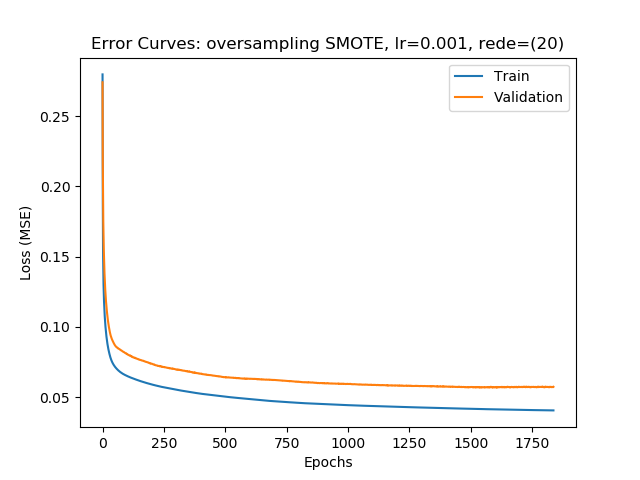

<IPython.core.display.Javascript object>


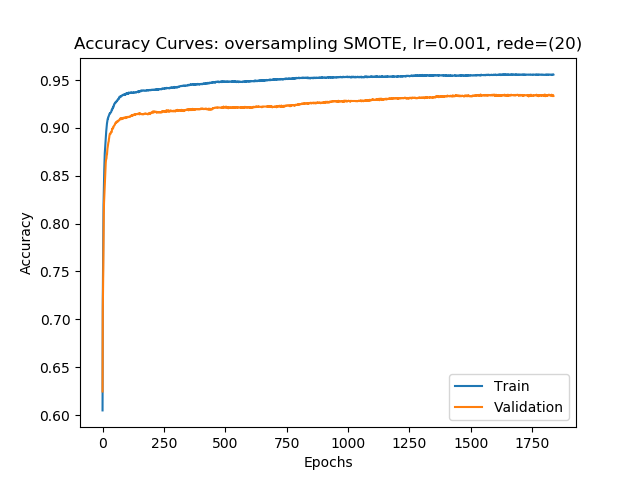

Matriz de confusão
[[1810   88]
 [   9   55]]

Train Loss:       0.0415
Validation Loss:  0.0568
Accuracy:         0.9506
MSE:              0.0494
AUROC:            0.9466


In [26]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [27]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.2536 - acc: 0.6009 - val_loss: 0.2443 - val_acc: 0.6805
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.1750 - acc: 0.7684 - val_loss: 0.2022 - val_acc: 0.7861
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.1422 - acc: 0.8550 - val_loss: 0.1765 - val_acc: 0.8438
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.1240 - acc: 0.8821 - val_loss: 0.1598 - val_acc: 0.8651
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.1126 - acc: 0.8919 - val_loss: 0.1482 - val_acc: 0.8743
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.1050 - acc: 0.8957 - val_loss: 0.1394 - val_acc: 0.8828
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0995 - acc: 0.8967 - val_loss: 0.1320 - val_acc: 0.8891
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0651 - acc: 0.9198 - val_loss: 0.0750 - val_acc: 0.9028
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9204 - val_loss: 0.0747 - val_acc: 0.9028
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9204 - val_loss: 0.0746 - val_acc: 0.9020
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9200 - val_loss: 0.0742 - val_acc: 0.9025
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9200 - val_loss: 0.0742 - val_acc: 0.9020
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9202 - val_loss: 0.0736 - val_acc: 0.9028
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9200 - val_loss: 0.0736 - val_acc: 0.9023
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9204 - val_loss: 0.0733 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9281 - val_loss: 0.0674 - val_acc: 0.9075
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9282 - val_loss: 0.0673 - val_acc: 0.9075
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9282 - val_loss: 0.0674 - val_acc: 0.9073
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9294 - val_loss: 0.0674 - val_acc: 0.9067
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9285 - val_loss: 0.0673 - val_acc: 0.9075
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9293 - val_loss: 0.0672 - val_acc: 0.9075
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9293 - val_loss: 0.0670 - val_acc: 0.9073
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9293 - val_loss: 0.0669 -

7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9322 - val_loss: 0.0650 - val_acc: 0.9107
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9316 - val_loss: 0.0650 - val_acc: 0.9110
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9322 - val_loss: 0.0649 - val_acc: 0.9110
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9318 - val_loss: 0.0649 - val_acc: 0.9112
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0546 - acc: 0.9320 - val_loss: 0.0648 - val_acc: 0.9110
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0546 - acc: 0.9323 - val_loss: 0.0646 - val_acc: 0.9115
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9319 - val_loss: 0.0647 - val_acc: 0.9110
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0545 - acc: 0.9328 - val_loss: 0.0647 -

7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9376 - val_loss: 0.0633 - val_acc: 0.9146
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9376 - val_loss: 0.0633 - val_acc: 0.9146
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9374 - val_loss: 0.0633 - val_acc: 0.9146
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9372 - val_loss: 0.0633 - val_acc: 0.9146
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9373 - val_loss: 0.0633 - val_acc: 0.9146
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9372 - val_loss: 0.0632 - val_acc: 0.9146
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9376 - val_loss: 0.0633 - val_acc: 0.9141
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9373 - val_loss: 0.0633 -

7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9426 - val_loss: 0.0623 - val_acc: 0.9162
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9424 - val_loss: 0.0622 - val_acc: 0.9165
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9423 - val_loss: 0.0622 - val_acc: 0.9162
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9427 - val_loss: 0.0621 - val_acc: 0.9170
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9430 - val_loss: 0.0621 - val_acc: 0.9168
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9424 - val_loss: 0.0622 - val_acc: 0.9168
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9430 - val_loss: 0.0621 - val_acc: 0.9165
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0500 - acc: 0.9430 - val_loss: 0.0621 -

7592/7592 [==============================] - 0s - loss: 0.0486 - acc: 0.9449 - val_loss: 0.0612 - val_acc: 0.9178
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9451 - val_loss: 0.0611 - val_acc: 0.9175
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9449 - val_loss: 0.0611 - val_acc: 0.9175
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9453 - val_loss: 0.0611 - val_acc: 0.9175
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9449 - val_loss: 0.0612 - val_acc: 0.9178
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9449 - val_loss: 0.0613 - val_acc: 0.9178
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0484 - acc: 0.9452 - val_loss: 0.0612 - val_acc: 0.9178
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0484 - acc: 0.9451 - val_loss: 0.0612 -

7592/7592 [==============================] - 0s - loss: 0.0472 - acc: 0.9457 - val_loss: 0.0605 - val_acc: 0.9181
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0472 - acc: 0.9460 - val_loss: 0.0605 - val_acc: 0.9183
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0472 - acc: 0.9455 - val_loss: 0.0605 - val_acc: 0.9178
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9459 - val_loss: 0.0605 - val_acc: 0.9181
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9456 - val_loss: 0.0605 - val_acc: 0.9181
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9455 - val_loss: 0.0606 - val_acc: 0.9191
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9456 - val_loss: 0.0604 - val_acc: 0.9183
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0471 - acc: 0.9459 - val_loss: 0.0604 -

7592/7592 [==============================] - 0s - loss: 0.0460 - acc: 0.9460 - val_loss: 0.0599 - val_acc: 0.9189
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0461 - acc: 0.9456 - val_loss: 0.0599 - val_acc: 0.9189
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0460 - acc: 0.9460 - val_loss: 0.0599 - val_acc: 0.9191
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0460 - acc: 0.9461 - val_loss: 0.0599 - val_acc: 0.9191
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0460 - acc: 0.9459 - val_loss: 0.0599 - val_acc: 0.9191
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0460 - acc: 0.9461 - val_loss: 0.0599 - val_acc: 0.9191
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0460 - acc: 0.9459 - val_loss: 0.0598 - val_acc: 0.9191
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0459 - acc: 0.9459 - val_loss: 0.0597 -

7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9460 - val_loss: 0.0593 - val_acc: 0.9197
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9461 - val_loss: 0.0594 - val_acc: 0.9199
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9460 - val_loss: 0.0593 - val_acc: 0.9202
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9464 - val_loss: 0.0593 - val_acc: 0.9202
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9468 - val_loss: 0.0593 - val_acc: 0.9204
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9465 - val_loss: 0.0593 - val_acc: 0.9202
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9463 - val_loss: 0.0593 - val_acc: 0.9204
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9461 - val_loss: 0.0592 -

7592/7592 [==============================] - 0s - loss: 0.0441 - acc: 0.9470 - val_loss: 0.0589 - val_acc: 0.9204
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0441 - acc: 0.9470 - val_loss: 0.0590 - val_acc: 0.9207
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0441 - acc: 0.9473 - val_loss: 0.0590 - val_acc: 0.9199
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9469 - val_loss: 0.0590 - val_acc: 0.9207
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9469 - val_loss: 0.0589 - val_acc: 0.9202
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9473 - val_loss: 0.0589 - val_acc: 0.9202
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9473 - val_loss: 0.0589 - val_acc: 0.9202
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9473 - val_loss: 0.0589 -

7592/7592 [==============================] - 0s - loss: 0.0432 - acc: 0.9469 - val_loss: 0.0585 - val_acc: 0.9207
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0432 - acc: 0.9477 - val_loss: 0.0586 - val_acc: 0.9207
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9472 - val_loss: 0.0586 - val_acc: 0.9204
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9477 - val_loss: 0.0586 - val_acc: 0.9204
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9474 - val_loss: 0.0585 - val_acc: 0.9207
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9474 - val_loss: 0.0586 - val_acc: 0.9207
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9473 - val_loss: 0.0585 - val_acc: 0.9207
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0431 - acc: 0.9473 - val_loss: 0.0586 -

7592/7592 [==============================] - 0s - loss: 0.0423 - acc: 0.9478 - val_loss: 0.0580 - val_acc: 0.9199
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0423 - acc: 0.9474 - val_loss: 0.0580 - val_acc: 0.9204
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0423 - acc: 0.9478 - val_loss: 0.0580 - val_acc: 0.9204
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0423 - acc: 0.9478 - val_loss: 0.0580 - val_acc: 0.9204
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0423 - acc: 0.9476 - val_loss: 0.0580 - val_acc: 0.9199
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0423 - acc: 0.9477 - val_loss: 0.0580 - val_acc: 0.9202
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0423 - acc: 0.9478 - val_loss: 0.0580 - val_acc: 0.9202
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9478 - val_loss: 0.0580 -

7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9478 - val_loss: 0.0576 - val_acc: 0.9197
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9480 - val_loss: 0.0576 - val_acc: 0.9204
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9480 - val_loss: 0.0576 - val_acc: 0.9202
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9477 - val_loss: 0.0576 - val_acc: 0.9202
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0415 - acc: 0.9480 - val_loss: 0.0575 - val_acc: 0.9204
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0415 - acc: 0.9478 - val_loss: 0.0577 - val_acc: 0.9197
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0415 - acc: 0.9478 - val_loss: 0.0576 - val_acc: 0.9199
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0415 - acc: 0.9478 - val_loss: 0.0576 -

7592/7592 [==============================] - 0s - loss: 0.0410 - acc: 0.9481 - val_loss: 0.0575 - val_acc: 0.9189
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9482 - val_loss: 0.0575 - val_acc: 0.9194
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9481 - val_loss: 0.0575 - val_acc: 0.9186
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9482 - val_loss: 0.0575 - val_acc: 0.9194
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9482 - val_loss: 0.0575 - val_acc: 0.9191
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9482 - val_loss: 0.0575 - val_acc: 0.9186
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9484 - val_loss: 0.0574 - val_acc: 0.9197
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0409 - acc: 0.9482 - val_loss: 0.0575 -

7592/7592 [==============================] - 0s - loss: 0.0404 - acc: 0.9488 - val_loss: 0.0573 - val_acc: 0.9183
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0404 - acc: 0.9482 - val_loss: 0.0573 - val_acc: 0.9178
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0404 - acc: 0.9482 - val_loss: 0.0574 - val_acc: 0.9181
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0404 - acc: 0.9486 - val_loss: 0.0574 - val_acc: 0.9181
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0403 - acc: 0.9485 - val_loss: 0.0573 - val_acc: 0.9178
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0403 - acc: 0.9481 - val_loss: 0.0574 - val_acc: 0.9178
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0403 - acc: 0.9484 - val_loss: 0.0574 - val_acc: 0.9181
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0403 - acc: 0.9482 - val_loss: 0.0574 -

7592/7592 [==============================] - 0s - loss: 0.0398 - acc: 0.9496 - val_loss: 0.0575 - val_acc: 0.9170
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0398 - acc: 0.9492 - val_loss: 0.0574 - val_acc: 0.9183
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0398 - acc: 0.9493 - val_loss: 0.0574 - val_acc: 0.9168
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0398 - acc: 0.9493 - val_loss: 0.0574 - val_acc: 0.9165
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0398 - acc: 0.9489 - val_loss: 0.0574 - val_acc: 0.9170
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0398 - acc: 0.9493 - val_loss: 0.0574 - val_acc: 0.9170
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0398 - acc: 0.9492 - val_loss: 0.0573 - val_acc: 0.9178
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0398 - acc: 0.9492 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9498 - val_loss: 0.0574 - val_acc: 0.9181
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9498 - val_loss: 0.0574 - val_acc: 0.9170
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9498 - val_loss: 0.0574 - val_acc: 0.9165
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9499 - val_loss: 0.0575 - val_acc: 0.9165
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9493 - val_loss: 0.0574 - val_acc: 0.9173
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9503 - val_loss: 0.0574 - val_acc: 0.9181
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9501 - val_loss: 0.0574 - val_acc: 0.9183
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0393 - acc: 0.9498 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0389 - acc: 0.9505 - val_loss: 0.0575 - val_acc: 0.9168
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0388 - acc: 0.9505 - val_loss: 0.0575 - val_acc: 0.9170
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0388 - acc: 0.9503 - val_loss: 0.0575 - val_acc: 0.9181
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0388 - acc: 0.9501 - val_loss: 0.0576 - val_acc: 0.9181
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0388 - acc: 0.9507 - val_loss: 0.0575 - val_acc: 0.9175
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0388 - acc: 0.9503 - val_loss: 0.0575 - val_acc: 0.9170
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0388 - acc: 0.9506 - val_loss: 0.0575 - val_acc: 0.9170
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0388 - acc: 0.9507 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0384 - acc: 0.9513 - val_loss: 0.0579 - val_acc: 0.9181
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0384 - acc: 0.9506 - val_loss: 0.0578 - val_acc: 0.9181
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0384 - acc: 0.9513 - val_loss: 0.0578 - val_acc: 0.9175
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0384 - acc: 0.9506 - val_loss: 0.0578 - val_acc: 0.9181
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0384 - acc: 0.9515 - val_loss: 0.0578 - val_acc: 0.9183
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0384 - acc: 0.9510 - val_loss: 0.0578 - val_acc: 0.9178
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0383 - acc: 0.9511 - val_loss: 0.0578 - val_acc: 0.9170
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0383 - acc: 0.9510 - val_loss: 0

In [28]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.043967821091322357, 0.94291539233515875]


<IPython.core.display.Javascript object>


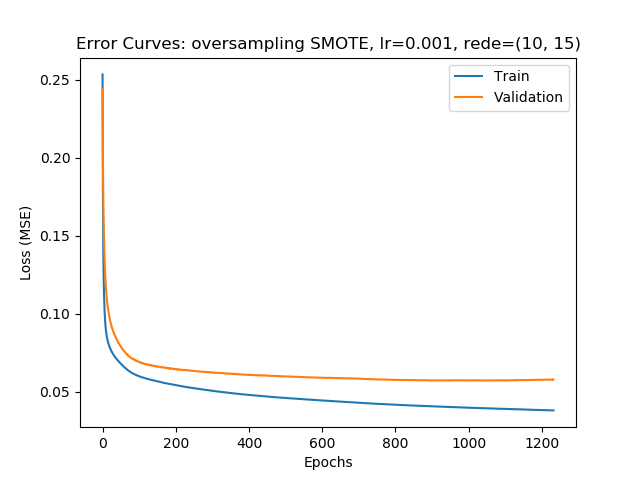

<IPython.core.display.Javascript object>


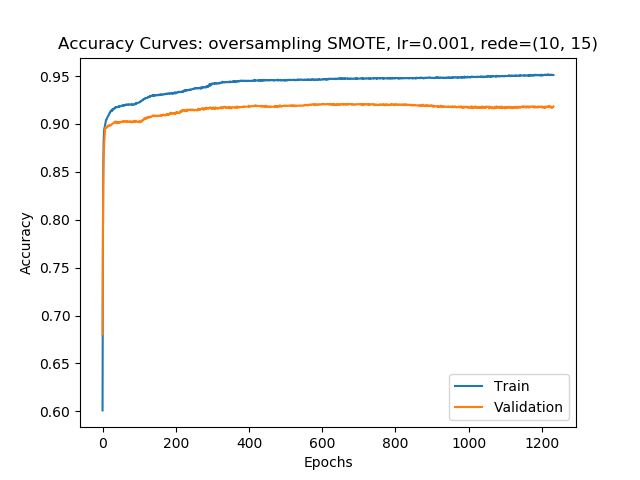

Matriz de confusão
[[1794  104]
 [   8   56]]

Train Loss:       0.0405
Validation Loss:  0.0573
Accuracy:         0.9429
MSE:              0.0571
AUROC:            0.9595


In [29]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history,graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [30]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.3679 - acc: 0.5194 - val_loss: 0.2759 - val_acc: 0.5382
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.2244 - acc: 0.6482 - val_loss: 0.2000 - val_acc: 0.7247
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.1776 - acc: 0.7625 - val_loss: 0.1822 - val_acc: 0.7827
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.1625 - acc: 0.7889 - val_loss: 0.1747 - val_acc: 0.8074
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.1535 - acc: 0.8091 - val_loss: 0.1693 - val_acc: 0.8185
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.1465 - acc: 0.8277 - val_loss: 0.1647 - val_acc: 0.8282
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.1407 - acc: 0.8404 - val_loss: 0.1604 - val_acc: 0.8343
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0778 - acc: 0.9095 - val_loss: 0.0957 - val_acc: 0.8949
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0776 - acc: 0.9103 - val_loss: 0.0954 - val_acc: 0.8954
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0774 - acc: 0.9103 - val_loss: 0.0951 - val_acc: 0.8959
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0771 - acc: 0.9104 - val_loss: 0.0948 - val_acc: 0.8959
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0769 - acc: 0.9107 - val_loss: 0.0946 - val_acc: 0.8962
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0767 - acc: 0.9111 - val_loss: 0.0944 - val_acc: 0.8965
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0765 - acc: 0.9112 - val_loss: 0.0940 - val_acc: 0.8967
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0763 - acc: 0.9116 - val_loss: 0.0937 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9190 - val_loss: 0.0870 - val_acc: 0.9009
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9193 - val_loss: 0.0869 - val_acc: 0.9009
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9193 - val_loss: 0.0866 - val_acc: 0.9004
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9199 - val_loss: 0.0869 - val_acc: 0.9012
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9193 - val_loss: 0.0866 - val_acc: 0.9012
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9199 - val_loss: 0.0866 - val_acc: 0.9012
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9199 - val_loss: 0.0867 - val_acc: 0.9012
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9200 - val_loss: 0.0865 -

7592/7592 [==============================] - 0s - loss: 0.0671 - acc: 0.9226 - val_loss: 0.0844 - val_acc: 0.9028
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0670 - acc: 0.9224 - val_loss: 0.0843 - val_acc: 0.9031
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0670 - acc: 0.9229 - val_loss: 0.0842 - val_acc: 0.9031
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0670 - acc: 0.9233 - val_loss: 0.0842 - val_acc: 0.9033
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0669 - acc: 0.9232 - val_loss: 0.0842 - val_acc: 0.9025
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0669 - acc: 0.9237 - val_loss: 0.0843 - val_acc: 0.9025
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0669 - acc: 0.9232 - val_loss: 0.0843 - val_acc: 0.9020
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0668 - acc: 0.9231 - val_loss: 0.0842 -

7592/7592 [==============================] - 0s - loss: 0.0654 - acc: 0.9260 - val_loss: 0.0830 - val_acc: 0.9038
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0654 - acc: 0.9253 - val_loss: 0.0828 - val_acc: 0.9041
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0654 - acc: 0.9256 - val_loss: 0.0829 - val_acc: 0.9041
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0654 - acc: 0.9256 - val_loss: 0.0828 - val_acc: 0.9041
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0654 - acc: 0.9253 - val_loss: 0.0828 - val_acc: 0.9036
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0653 - acc: 0.9260 - val_loss: 0.0828 - val_acc: 0.9038
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0653 - acc: 0.9260 - val_loss: 0.0827 - val_acc: 0.9033
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0653 - acc: 0.9260 - val_loss: 0.0827 -

7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9268 - val_loss: 0.0818 - val_acc: 0.9060
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9266 - val_loss: 0.0817 - val_acc: 0.9060
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9270 - val_loss: 0.0818 - val_acc: 0.9060
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9270 - val_loss: 0.0818 - val_acc: 0.9062
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9270 - val_loss: 0.0816 - val_acc: 0.9054
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9272 - val_loss: 0.0817 - val_acc: 0.9062
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9269 - val_loss: 0.0816 - val_acc: 0.9057
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9266 - val_loss: 0.0816 -

7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9282 - val_loss: 0.0808 - val_acc: 0.9107
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9280 - val_loss: 0.0808 - val_acc: 0.9112
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9283 - val_loss: 0.0808 - val_acc: 0.9107
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9282 - val_loss: 0.0808 - val_acc: 0.9112
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9282 - val_loss: 0.0808 - val_acc: 0.9110
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9282 - val_loss: 0.0808 - val_acc: 0.9115
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9283 - val_loss: 0.0807 - val_acc: 0.9112
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9285 - val_loss: 0.0806 -

7592/7592 [==============================] - 0s - loss: 0.0617 - acc: 0.9319 - val_loss: 0.0802 - val_acc: 0.9112
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0617 - acc: 0.9316 - val_loss: 0.0801 - val_acc: 0.9107
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0617 - acc: 0.9320 - val_loss: 0.0802 - val_acc: 0.9112
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0617 - acc: 0.9323 - val_loss: 0.0801 - val_acc: 0.9107
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0617 - acc: 0.9326 - val_loss: 0.0801 - val_acc: 0.9110
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0616 - acc: 0.9326 - val_loss: 0.0802 - val_acc: 0.9107
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0616 - acc: 0.9326 - val_loss: 0.0802 - val_acc: 0.9110
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0616 - acc: 0.9328 - val_loss: 0.0802 -

7592/7592 [==============================] - 0s - loss: 0.0605 - acc: 0.9334 - val_loss: 0.0795 - val_acc: 0.9099
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9334 - val_loss: 0.0794 - val_acc: 0.9102
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9328 - val_loss: 0.0794 - val_acc: 0.9099
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9334 - val_loss: 0.0793 - val_acc: 0.9102
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9330 - val_loss: 0.0794 - val_acc: 0.9102
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9331 - val_loss: 0.0794 - val_acc: 0.9099
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9331 - val_loss: 0.0793 - val_acc: 0.9102
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9332 - val_loss: 0.0794 -

7592/7592 [==============================] - 0s - loss: 0.0590 - acc: 0.9348 - val_loss: 0.0790 - val_acc: 0.9099
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0590 - acc: 0.9345 - val_loss: 0.0789 - val_acc: 0.9099
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0590 - acc: 0.9345 - val_loss: 0.0789 - val_acc: 0.9099
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0590 - acc: 0.9345 - val_loss: 0.0790 - val_acc: 0.9102
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0589 - acc: 0.9347 - val_loss: 0.0789 - val_acc: 0.9102
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0589 - acc: 0.9348 - val_loss: 0.0791 - val_acc: 0.9099
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0589 - acc: 0.9344 - val_loss: 0.0789 - val_acc: 0.9099
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0589 - acc: 0.9349 - val_loss: 0.0789 -

7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9357 - val_loss: 0.0785 - val_acc: 0.9102
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9355 - val_loss: 0.0785 - val_acc: 0.9104
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9359 - val_loss: 0.0784 - val_acc: 0.9102
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9360 - val_loss: 0.0785 - val_acc: 0.9104
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9359 - val_loss: 0.0785 - val_acc: 0.9104
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9359 - val_loss: 0.0785 - val_acc: 0.9104
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9359 - val_loss: 0.0785 - val_acc: 0.9107
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9356 - val_loss: 0.0785 -

7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9378 - val_loss: 0.0782 - val_acc: 0.9117
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9376 - val_loss: 0.0782 - val_acc: 0.9117
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9376 - val_loss: 0.0783 - val_acc: 0.9120
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9372 - val_loss: 0.0784 - val_acc: 0.9120
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9376 - val_loss: 0.0782 - val_acc: 0.9117
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9376 - val_loss: 0.0784 - val_acc: 0.9120
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9380 - val_loss: 0.0783 - val_acc: 0.9120
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9380 - val_loss: 0.0783 -

7592/7592 [==============================] - 0s - loss: 0.0554 - acc: 0.9395 - val_loss: 0.0783 - val_acc: 0.9125
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0554 - acc: 0.9394 - val_loss: 0.0784 - val_acc: 0.9125
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0554 - acc: 0.9393 - val_loss: 0.0785 - val_acc: 0.9133
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0554 - acc: 0.9394 - val_loss: 0.0785 - val_acc: 0.9128
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0553 - acc: 0.9398 - val_loss: 0.0784 - val_acc: 0.9131
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0553 - acc: 0.9397 - val_loss: 0.0784 - val_acc: 0.9128
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0553 - acc: 0.9397 - val_loss: 0.0785 - val_acc: 0.9131
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0553 - acc: 0.9401 - val_loss: 0.0784 -

7592/7592 [==============================] - 0s - loss: 0.0543 - acc: 0.9416 - val_loss: 0.0788 - val_acc: 0.9133
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9416 - val_loss: 0.0787 - val_acc: 0.9136
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9414 - val_loss: 0.0787 - val_acc: 0.9136
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9414 - val_loss: 0.0788 - val_acc: 0.9133
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9415 - val_loss: 0.0787 - val_acc: 0.9136
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9416 - val_loss: 0.0787 - val_acc: 0.9136
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0542 - acc: 0.9414 - val_loss: 0.0787 - val_acc: 0.9136
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0541 - acc: 0.9415 - val_loss: 0.0788 -

7592/7592 [==============================] - 0s - loss: 0.0534 - acc: 0.9424 - val_loss: 0.0789 - val_acc: 0.9128
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0534 - acc: 0.9424 - val_loss: 0.0789 - val_acc: 0.9133
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0533 - acc: 0.9423 - val_loss: 0.0789 - val_acc: 0.9128
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0533 - acc: 0.9422 - val_loss: 0.0789 - val_acc: 0.9128
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0533 - acc: 0.9423 - val_loss: 0.0789 - val_acc: 0.9125
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0533 - acc: 0.9423 - val_loss: 0.0789 - val_acc: 0.9125
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0533 - acc: 0.9423 - val_loss: 0.0789 - val_acc: 0.9128
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0533 - acc: 0.9422 - val_loss: 0.0790 -

7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9424 - val_loss: 0.0791 - val_acc: 0.9123
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9427 - val_loss: 0.0791 - val_acc: 0.9123
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9428 - val_loss: 0.0791 - val_acc: 0.9123
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9430 - val_loss: 0.0791 - val_acc: 0.9117
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9424 - val_loss: 0.0792 - val_acc: 0.9112
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9431 - val_loss: 0.0791 - val_acc: 0.9117
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9427 - val_loss: 0.0792 - val_acc: 0.9115
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9432 - val_loss: 0.0791 -

In [31]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.03725662444270559, 0.94852191629030658]


<IPython.core.display.Javascript object>


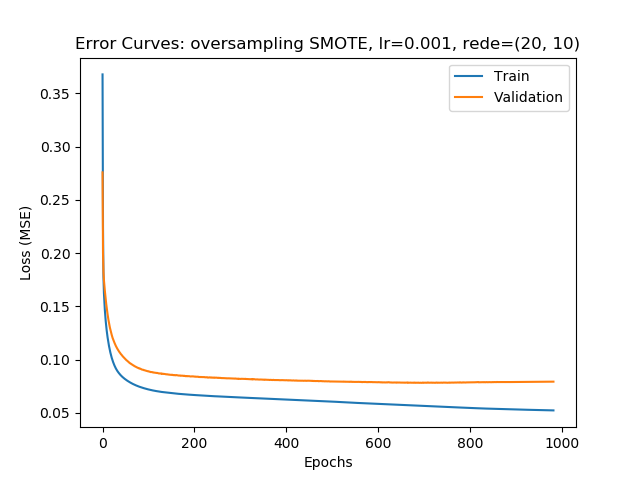

<IPython.core.display.Javascript object>


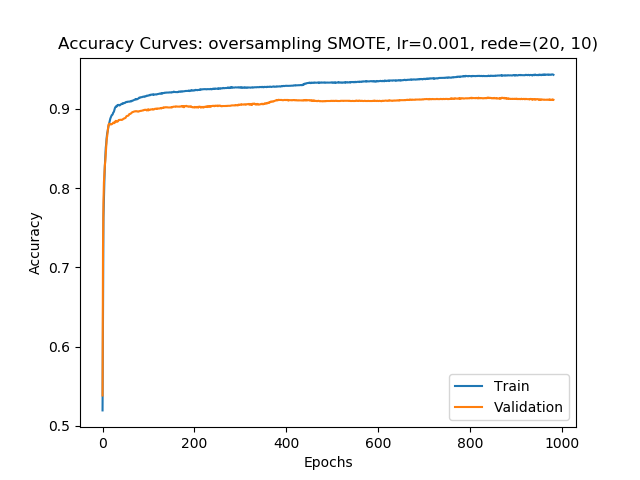

Matriz de confusão
[[1805   93]
 [   8   56]]

Train Loss:       0.0569
Validation Loss:  0.0782
Accuracy:         0.9485
MSE:              0.0515
AUROC:            0.9359


In [32]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [ ]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history, graficoName + "(2)")
plot_training_acc_curves(history, graficoName + "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [ ]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history, graficoName + "(4)")
plot_training_acc_curves(history, graficoName + "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))